In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import sys
import time
import random
import pickle
import math
import argparse
import os
import torch
import numpy as np

import sys
os.environ["CODE_REPO_PATH"]="/home/haokunliu/past-interaction-learning"
code_repo_path = os.environ.get("CODE_REPO_PATH")
sys.path.append(f'{code_repo_path}/code')
from prompt_support_mixtral import PROMPT_DICT
from data_loader import get_train_data, get_data
from experiments.hypotheses_generation_batched import run_inference
from utils import LLMWrapper

Code repo path: /home/haokunliu/past-interaction-learning
Code repo path: /home/haokunliu/past-interaction-learning
Code repo path: /home/haokunliu/past-interaction-learning
Code repo path: /home/haokunliu/past-interaction-learning
Code repo path: /home/haokunliu/past-interaction-learning


In [14]:
# model = 'Mixtral-8x7B'
model = 'claude_2'
args = {
    'cache_dir': "/net/scratch/haokunliu/Mixtral_cache",
    'path_name': "/net/projects/veitch/LLMs/llama2-based-models/llama2-hf/"+model+"-hf/"
}

api = LLMWrapper(model,**args)

In [15]:
task_name = 'headline_binary'
prompt_class = PROMPT_DICT[task_name]()
train_data, _ = get_data(task_name,20,100)
prompt = prompt_class.generate_hypothesis(train_data,6,api.model)
print(prompt)
prompt = prompt_class.inference_without_reasoning("Some hypothesis.",train_data,0,api.model)
print(prompt)

task_name: headline_binary
###
Instruction:
You are a writer for an online newspaper company. So you are excellent at determining which headlines are more likely to cause users to click on the article.  
You will be given a set of observations of the format:
Headline 1 [headline]
Headline 2 [headline]
Observation: [observation]. 
Based on the observations, generate hypotheses that are useful for explaining why headlines are clicked more than others. 
Please be concise and keep each hypothesis to be one-sentence long. Propose 6 possible hypotheses. 
Generate them in the format of 1. [hypothesis], 2. [hypothesis], ... n. [hypothesis]. 
Please make the hypotheses general enough to be applicable to new observations.
###
Here are the Observations:
Example 1:
Headline 1: Composting 101: Why It's The Greatest, And How To Do It Yourself Clicks: low
Headline 2: The Last Thing Your Veggies Want Is To Be Tossed In The Trash. Here's A Better Idea. Clicks: high
Observation: Headline 2 has more clic

In [5]:
outputs = api.generate(prompt)

In [6]:
print(outputs)



1. Reviews with excessive use of superlatives (e.g., "best hotel ever," "most amazing experience") may be deceptive.
2. Reviews with specific complaints about room cleanliness, bed quality, or staff behavior may be truthful.
3. Reviews that mention a discounted rate or special offer may be biased towards a positive evaluation.
4. Reviews that mention a negative experience with a specific hotel staff member may be truthful.
5. Reviews that contain multiple positive comments about the hotel's location may be truthful.

These hypotheses are based on the assumption that truthful reviews are more likely to contain specific complaints or negative experiences, while deceptive reviews may contain excessive praise or biased evaluations. However, it's important to note that these hypotheses are not definitive and should be tested with a larger dataset of hotel reviews.


In [3]:
num_test = 100
train_sizes = [1,3,6,12,25,50,100]
SEEDS = [1,2,3]
num_hypothesis = 5
best_hypotheses_all = []
test_accs = []

for num_train in train_sizes:
    best_hypotheses = []
    test_acc_trial = 0
    for SEED in SEEDS:
        test_pred,test_acc,best_hypothesis = run_inference(api,'shoe',num_train,num_test,num_hypothesis)
        best_hypotheses.append(best_hypothesis)
        test_acc_trial += test_acc
        break
    test_accs.append(test_acc_trial/len(SEEDS))
    best_hypotheses_all.append(best_hypotheses)
    break

task_name: shoe
******* information_prompt *******
A customer is a old and short woman with white hat, green shirt, and a small orange bag. This customer bought a pair of green shoes.

**********************************
******* generate_hypothesis *******
[INST] You're a helpful assistant. Your task is given as follows:
Given a set of observations, we want to generate hypotheses that are useful for predicting the color of the shoes given the appearance of the person. 
Please be concise and keep the hypotheses to be one-sentence long.  
Please generate them in the format of 
{1. [hypothesis]. 
2. [hypothesis].
... 
5. [hypothesis].}
Only propose 5 possible hypotheses in total.
No need to explain the hypotheses.[/INST]
We made some observations:
A customer is a old and short woman with white hat, green shirt, and a small orange bag. This customer bought a pair of green shoes.
Based on the above observations, generate 5 hypotheses.
Please be concise and keep the hypotheses to be one-sente

Text(0.5, 1.0, 'Shoe dataset, bached version Mixtral-8x7B')

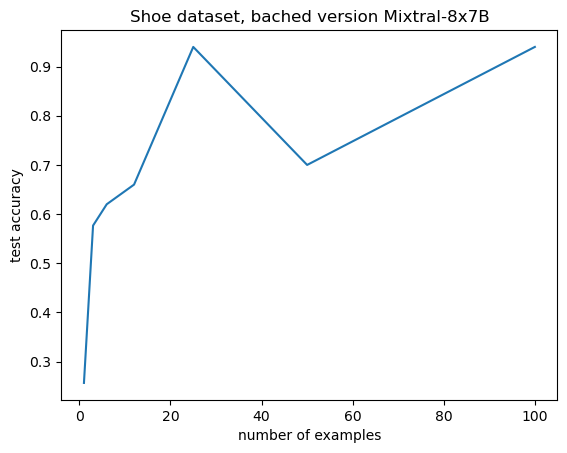

In [17]:
import matplotlib.pyplot as plt
plt.plot(train_sizes,test_accs)
plt.xlabel("number of examples")
plt.ylabel("test accuracy")
plt.title("Shoe dataset, bached version "+model)

In [15]:
i=0
for train_size in train_sizes:
    print(f'Number of train examples: {train_size}')
    for hypothesis in best_hypotheses_all[i]:
        print(hypothesis)
    i+=1

Number of train examples: 1
The color of a person's shoes often matches the color of their bag.
Customers who wear orange shirts are likely to buy orange shoes.

Customers carrying blue bags are likely to buy red shoes.

Number of train examples: 3
The person is wearing white shoes if they are carrying a bag of a different color than their shoes.
The person is wearing shoes of the same color as their shirt.

The customer's shoe color is likely to be the same as the color of their shirt.

Number of train examples: 6
The customer's shoe color is the same color as the dominant color in their outfit.
The customer is young and carries a small bag, they are likely to buy shoes of the color of their shirt.

The customer's gender may influence the color of their shoe purchase.

Number of train examples: 12
The customer's shoe color matches the color of their shirt.

The customer's shoe color matches the dominant color in their outfit.

The customer's shoe color matches the color of their shirt